# This notebook must be run with the ABC_Download conda environment within the ABC.sif singularity container

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
import seaborn as sns

In [2]:
adata = sc.read_h5ad('ABC_transferred.h5ad')

annotation_file = '/hpc/projects/group.quake/doug/references/ABC/AIT17.0.cl.df.v6_lock_230504/AIT17.0.cl.df.v6_lock_230504.tsv'

annotation_df = pd.read_csv(annotation_file, sep='\t')
annotation_df['cl'] = annotation_df['cl'].astype(str)

mapping_dict = pd.Series(annotation_df.class_label.values, index=annotation_df.subclass_label).to_dict()

# Map the subclass labels to class labels
adata.obs['class'] = adata.obs['subclass_label_transfer'].map(mapping_dict)

In [3]:
region_class_mapping = {
    "Cerebellum": ["CB Glut", "CB Sero", "CB GABA"],
    "Basal_Ganglia": ["P GABA", "NP-CT-L6b Glut", "LSX GABA"],
    "Cortex": ["IT-ET Glut"],
    "Hippocampus": ["MOB-DG-IMN", "MOB-CR Glut"],
    "Hypothalamus": ["HY GABA", "HY Glut", "HY MM Glut", "HY Gnrh1 Glut"],
    "MPM": ["MB Glut", "MB GABA", "MB Dopa", "MB-HB Sero"],
    "Thalamus": ["TH Glut"],
    "Unlabeled": []  # No specific class for unlabeled, leave as is
}

# Define the classes not associated with regions
non_region_classes = ["Oligo", "OEG", "Vascular", "Immune", "Astro-Epen"]

# Function to map subclass to the corresponding region class based on the last word
def map_to_region_class(subclass, region):
    if subclass in non_region_classes or region == "Unlabeled":
        return subclass  # No change needed
    if subclass == "MOB-DG-IMN" and region == "Cerebellum":
        return "CB Glut"  # Special case for MOB-DG-IMN in the Cerebellum
    if region in region_class_mapping:
        subclass_last_word = subclass.split()[-1]
        for target_class in region_class_mapping[region]:
            if target_class.split()[-1] == subclass_last_word:
                return target_class
    return subclass

# Apply the mapping to create the new 'class' column
adata.obs['class'] = adata.obs.apply(
    lambda row: map_to_region_class(row['class'], row['Brain_Region']), axis=1
)

def fine_tune_based_on_leiden(row):
    if row['class'] == 'Immune' and row['leiden'] == '24':
        return 'Microglia'
    elif row['class'] == 'Oligo' and row['leiden'] == '5':
        return 'Oligodendrocytes'
    elif row['class'] == 'Oligo' and row['leiden'] == '15':
        return 'OPC'
    elif row['class'] == 'Astro-Epen':
        if row['leiden'] == '28':
            return 'Ependymal cells'
        elif row['leiden'] in ['6', '19']:
            return 'Bergmann glia'
        else:
            return 'Astrocytes'
    return row['class']

# Apply the fine-tuning to the 'class' column
adata.obs['class'] = adata.obs.apply(fine_tune_based_on_leiden, axis=1)


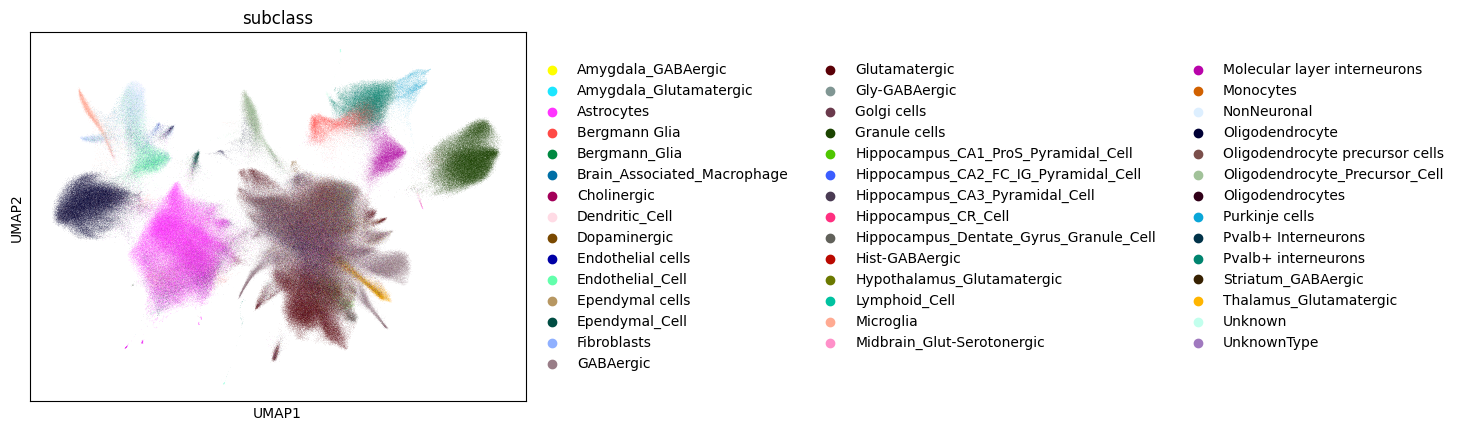

In [4]:
# Define brain regions and neurotransmitter types
explicit_mappings = {
    'OPC NN': 'Oligodendrocyte_Precursor_Cell',
    'BAM NN': 'Brain_Associated_Macrophage',
    'Astro-OLF NN': 'Astrocytes',
    'Bergmann NN': 'Bergmann_Glia',
    'Lymphoid NN': 'Lymphoid_Cell',
    'Astro-CB NN': 'Astrocytes',
    'Astroependymal NN': 'Ependymal_Cell',
    'DC NN': 'Dendritic_Cell',
    'Ependymal NN': 'Ependymal_Cell',
    'Hypendymal NN': 'Ependymal_Cell',
    'Monocytes NN': 'Monocytes',
    'Astro-TE NN': 'Astrocytes',
    'Astro-NT NN': 'Astrocytes',
    'Endo NN': 'Endothelial_Cell',
    'Microglia NN': 'Microglia',
    'CB Granule Glut': 'Cerebellar Granule',
    'CBX Purkinje Gaba': 'Cerebellar Purkinje',
    'CBX MLI Megf11 Gaba': 'Cerebellar Molecular Layer Interneuron',
    'CBX MLI Cdh22 Gaba': 'Cerebellar Molecular Layer Interneuron',
    'DCO UBC Glut': 'Cerebellar Unipolar Brush',
    'DCO Il22 Gly-Gaba': 'Cerebellar Golgi',
    'DG Glut': 'Hippocampus_Dentate_Gyrus_Granule_Cell',
    'CA1-ProS Glut': 'Hippocampus_CA1_ProS_Pyramidal_Cell',
    'CA2-FC-IG Glut': 'Hippocampus_CA2_FC_IG_Pyramidal_Cell',
    'CA3 Glut': 'Hippocampus_CA3_Pyramidal_Cell',
    'HPF CR Glut': 'Hippocampus_CR_Cell',
    'Oligo NN': 'Oligodendrocyte'
}

# Define brain regions and neurotransmitter types
brain_regions = {
    'CTX': 'Cortex',
    'STR': 'Striatum',
    'MEA': 'Amygdala',
    'TH': 'Thalamus',
    'HY': 'Hypothalamus',
    'MB': 'Midbrain',
    'HB': 'Hindbrain'
}

neurotransmitter_types = {
    'Gaba': 'GABAergic',
    'Glut': 'Glutamatergic',
    'Dopa': 'Dopaminergic',
    'Gly-Gaba': 'Gly-GABAergic',
    'Chol': 'Cholinergic',
    'Hist-Gaba': 'Hist-GABAergic',
    'Glut-Sero': 'Glut-Serotonergic',
    'NN': 'NonNeuronal'
}

def categorize_celltype(cell_type):
    if cell_type in explicit_mappings:
        return explicit_mappings[cell_type]
    
    parts = cell_type.split(' ')
    region_marker = parts[0].split('-')[0]
    neurotransmitter_marker = parts[-1]
    
    region = brain_regions.get(region_marker, neurotransmitter_types.get(neurotransmitter_marker, 'UnknownType'))
    neurotransmitter_type = neurotransmitter_types.get(neurotransmitter_marker, 'UnknownType')
    
    return f"{region}_{neurotransmitter_type}" if region != neurotransmitter_type else neurotransmitter_type

# Apply the categorization to the 'subclass_label_transfer' column and create a new 'subclass' column
adata.obs['subclass'] = adata.obs['subclass_label_transfer'].apply(categorize_celltype)

adata.obs.loc[adata.obs['Brain_Region'] == 'Cerebellum', 'subclass'] = adata.obs.loc[adata.obs['Brain_Region'] == 'Cerebellum', 'updated_celltype']

cerebellum_updates = {
    'Cerebellar Golgi': 'GABAergic',
    'Cerebellar Purkinje': 'GABAergic',
    'Cerebellar Granule': 'Glutamatergic',
    'Cerebellar Unipolar Brush': 'Glutamatergic',
    'Cerebellar Molecular Layer Interneuron': 'GABAergic'
}

for original, updated in cerebellum_updates.items():
    adata.obs.loc[adata.obs['subclass'] == original, 'subclass'] = updated


# Convert the 'subclass' column to a categorical type
adata.obs['subclass'] = adata.obs['subclass'].astype('category')

#num_categories = adata.obs['subclass'].nunique()
#palette = sns.color_palette("tab20", num_categories)
#adata.uns['subclass_colors'] = palette

# Plot the UMAP
sc.pl.umap(adata, color=['subclass'])

In [5]:
adata.write_h5ad('ABC_cleaned.h5ad')